In [1]:
# Transformers installation
! pip install transformers datasets evaluate -q
# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.3 MB/s eta 0:00:00


In [2]:
from transformers import pipeline
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax, rel_entr
from scipy.stats import entropy
from sklearn.metrics.pairwise import cosine_similarity
import ast
import math
import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

### Load data from file which has cleaned annotations and majority, minority is calculated  ###

In [4]:
df = pd.read_csv("/content/intermodel_cleaned_maj_min.csv")

In [5]:
# Convert string representations back to lists, replacing None or NaN with None
columns_to_convert = ['human_annots', 'model_annots', 'machine_majority', 'machine_minority', 'human_majority', 'human_minority']
for column in columns_to_convert:
    df[column] = df[column].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else None)

In [6]:
df.head()

,model_name,dataset_name,text_ind,text,prompt,human_annots,model_annots,human_majority,machine_majority,human_minority,machine_minority
0,vicuna,SChem5Labels,0,You should support your partner.,"For this task, we want to study people's every...","[3.0, 4.0, 3.0, 4.0, 3.0]","[4.0, 3.0, 3.0, 4.0, 3.0]",[3.0],[3.0],[4.0],[4.0]
1,vicuna,SChem5Labels,1,It's good to be want to know things that could...,"For this task, we want to study people's every...","[3.0, 3.0, 3.0, 4.0, 4.0]","[0.0, 3.0, 3.0, 4.0, 3.0]",[3.0],[3.0],[4.0],"[0.0, 4.0]"
2,vicuna,SChem5Labels,2,It is good to have moderation in all activities.,"For this task, we want to study people's every...","[2.0, 3.0, 2.0, 3.0, 4.0]","[3.0, 3.0, 3.0, 4.0, 3.0]","[2.0, 3.0]",[3.0],[4.0],[4.0]
3,vicuna,SChem5Labels,3,It is wrong to be racist to other people.,"For this task, we want to study people's every...","[3.0, 4.0, 3.0, 3.0, 3.0]","[1.0, 3.0, 3.0, 4.0, 3.0]",[3.0],[3.0],[4.0],"[1.0, 4.0]"
4,vicuna,SChem5Labels,4,It's normal to be clean-shaven for special occ...,"For this task, we want to study people's every...","[2.0, 3.0, 2.0, 3.0, 2.0]","[2.0, 3.0, 3.0, 4.0, 3.0]",[2.0],[3.0],[3.0],"[2.0, 4.0]"


In [7]:
df.dtypes

model_name          object
dataset_name        object
text_ind             int64
text                object
prompt              object
human_annots        object
model_annots        object
human_majority      object
machine_majority    object
human_minority      object
machine_minority    object
dtype: object

In [8]:
df['model_name'].value_counts()

vicuna                8079
baize                 8079
llama2                8079
koala                 8079
open_ai_gpt35turbo    8079
Name: model_name, dtype: int64

In [9]:
df['dataset_name'].value_counts()

SBIC            15635
ghc             13775
Sentiment        7035
SChem5Labels     3950
Name: dataset_name, dtype: int64

In [10]:
def equal_list(list1, list2): # if there's an intersection in the majorities or minorities there's a match
    if list1==None or list2==None:
        return False
    set1 = set(list1)
    set2 = set(list2)
    if set1 & set2 :
        return True
    else :
        return False

def accuracy_match(row, majority_flag = True):
    if majority_flag:
        human =row['human_majority']
        machine =row['machine_majority']
    else:
        human =row['human_minority']
        machine =row['machine_minority']
    if equal_list(human, machine):
        return True
    else:
        return False

In [11]:
df['majority_match']= df.apply(lambda x:accuracy_match(x, majority_flag= True), axis=1)
df['minority_match']= df.apply(lambda x:accuracy_match(x, majority_flag= False), axis=1)

In [12]:
# Group by model_name and compute accuracy
model_group = df.groupby('model_name').agg(
    majority_accuracy=('majority_match', 'mean'),
    minority_accuracy=('minority_match', 'mean')
) * 100

# Group by dataset_name and compute accuracy
dataset_group = df.groupby('dataset_name').agg(
    majority_accuracy=('majority_match', 'mean'),
    minority_accuracy=('minority_match', 'mean')
) * 100

### Majority Minority Match Plot ###

In [13]:
# plotting the graphs each one by one

# Assuming df is your DataFrame
dataset_names = df['dataset_name'].unique()

# Define the mapping of original model names to new names
model_name_mapping = {
    'llama2': 'llama',
    'open_ai_gpt35turbo': 'chatgpt'
}

# Update the DataFrame with the new model names
df['model_name'] = df['model_name'].replace(model_name_mapping)

# Define the desired X-axis order with updated model names
model_order = ['baize', 'koala', 'llama', 'vicuna', 'chatgpt']

for i, dataset in enumerate(dataset_names):
    # Create a new figure for each dataset
    fig, ax = plt.subplots(figsize=(7.5, 5))

    # Filtering data for each dataset
    dataset_df = df[df['dataset_name'] == dataset]

    # Grouping by model_name and then calculating the mean for majority_match and minority_match
    model_group = dataset_df.groupby('model_name').agg(
        M=('majority_match', 'mean'),  # M for majority
        m=('minority_match', 'mean')   # m for minority
    ) * 100

    # Reindex the DataFrame to the specified order before plotting
    model_group = model_group.reindex(model_order)

    # Creating bar chart for each grouped dataset with specified colors
    model_group.plot(kind='bar', ax=ax, color=['blue', 'red'])

    # Setting font sizes
    ax.set_title(dataset, fontsize=18)
    ax.set_ylabel("Accuracy (%)", fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=18)

    # Set x-axis tick labels to model names and remove the xlabel
    ax.set_xticklabels(model_group.index, rotation=45)
    ax.set_xlabel('')

    # Custom legend with fontsize
    ax.legend(title=None, fontsize=18)

    plt.tight_layout()
    #plt.show()

    # Save each plot as a separate PDF
    plt.savefig(f"{dataset}_accuracy.pdf", format='pdf', bbox_inches='tight', dpi=300)
    plt.savefig(f"{dataset}_accuracy.jpg", format='jpg')
    plt.close(fig)  # Close the figure to free up memory


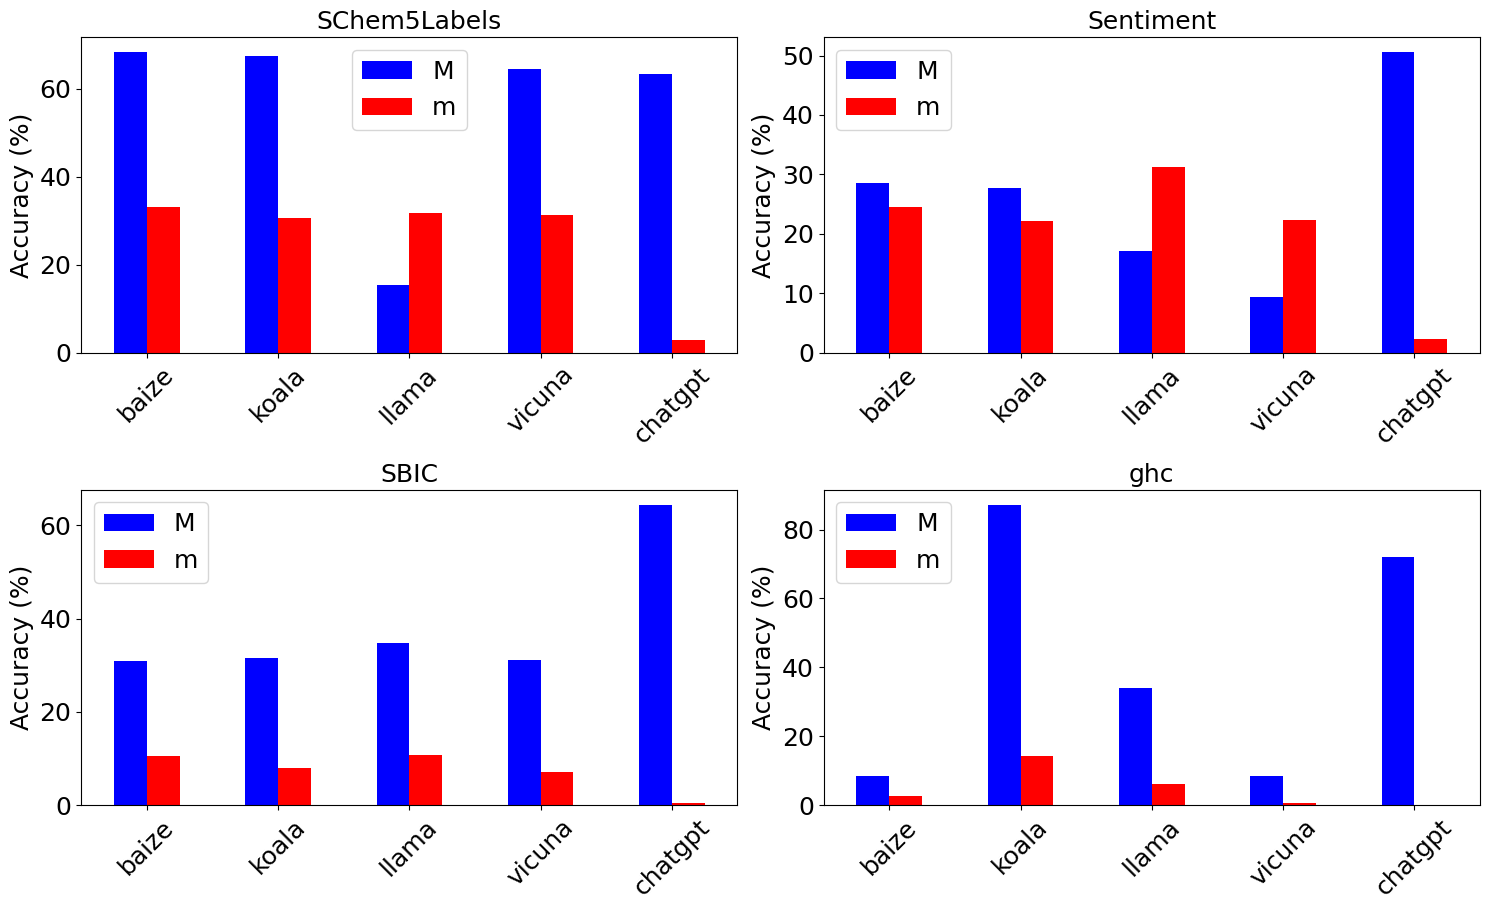

In [14]:
#plotting them all in one graph
# Assuming df is your DataFrame
dataset_names = df['dataset_name'].unique()

# Define the mapping of original model names to new names
model_name_mapping = {
    'llama2': 'llama',
    'open_ai_gpt35turbo': 'chatgpt'
}

# Update the DataFrame with the new model names
df['model_name'] = df['model_name'].replace(model_name_mapping)

# Define the desired X-axis order with updated model names
model_order = ['baize', 'koala', 'llama', 'vicuna', 'chatgpt']

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for i, dataset in enumerate(dataset_names):
    ax = axs[i//2, i%2]
    # Filtering data for each dataset
    dataset_df = df[df['dataset_name'] == dataset]

    # Grouping by model_name and then calculating the mean for majority_match and minority_match
    model_group = dataset_df.groupby('model_name').agg(
        M=('majority_match', 'mean'),  # M for majority
        m=('minority_match', 'mean')   # m for minority
    ) * 100

    # Reindex the DataFrame to the specified order before plotting
    model_group = model_group.reindex(model_order)

    # Creating bar chart for each grouped dataset with specified colors
    model_group.plot(kind='bar', ax=ax, color=['blue', 'red'])

    # Setting font sizes
    ax.set_title(dataset, fontsize=18)
    ax.set_ylabel("Accuracy (%)", fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=18)

    # Set x-axis tick labels to model names and remove the xlabel
    ax.set_xticklabels(model_group.index, rotation=45)
    ax.set_xlabel('')

    # Custom legend with fontsize
    ax.legend(title=None, fontsize=18)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("majority_minority.pdf", format='pdf', bbox_inches='tight', dpi=300)
plt.show()


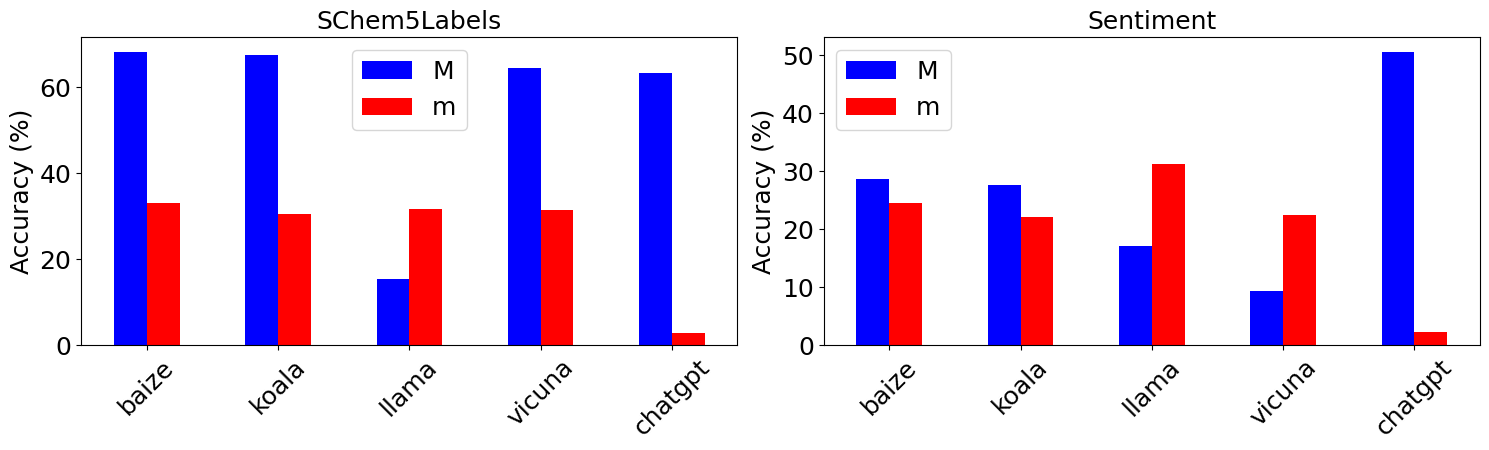

In [15]:
#plotting only top two
# Initialize the subplots for the top two datasets only
fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # Changed to 1 row, 2 columns

# Loop over the first two datasets only
for i, dataset in enumerate(dataset_names[:2]):  # Limit to first two datasets
    ax = axs[i]

    # Filtering data for each dataset
    dataset_df = df[df['dataset_name'] == dataset]

    # Grouping by model_name and then calculating the mean for majority_match and minority_match
    model_group = dataset_df.groupby('model_name').agg(
        M=('majority_match', 'mean'),  # M for majority
        m=('minority_match', 'mean')   # m for minority
    ) * 100

    # Reindex the DataFrame to the specified order before plotting
    model_group = model_group.reindex(model_order)

    # Creating bar chart for each grouped dataset with specified colors
    model_group.plot(kind='bar', ax=ax, color=['blue', 'red'])

    # Setting font sizes
    ax.set_title(dataset, fontsize=18)
    ax.set_ylabel("Accuracy (%)", fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=18)

    # Set x-axis tick labels to model names and remove the xlabel
    ax.set_xticklabels(model_group.index, rotation=45)
    ax.set_xlabel('')

    # Custom legend with fontsize
    ax.legend(title=None, fontsize=18)

# Adjust the layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save the figure
plt.savefig("majority_minority_top2.pdf", format='pdf', bbox_inches='tight', dpi=300)

# Show the plot
plt.show()

### Variation Analysis ###


In [16]:
def calculate_variation(df, column_name):
    return df[column_name].apply(lambda x: pd.Series(x).std())

df['human_variation'] = calculate_variation(df, 'human_annots')
df['model_variation'] = calculate_variation(df, 'model_annots')

Only with GPT3.5Turbo

In [17]:
# Filter by dataset_name and sort by human_variation
filtered_sorted_df = df[(df['dataset_name'] == 'SChem5Labels') & (df['model_name'] == 'chatgpt') ].sort_values(by='human_variation', ascending=False)
filtered_sorted_df.head()

,model_name,dataset_name,text_ind,text,prompt,human_annots,model_annots,human_majority,machine_majority,human_minority,machine_minority,majority_match,minority_match,human_variation,model_variation
3421,chatgpt,SChem5Labels,261,It is okay to be depressed.,"For this task, we want to study people's every...","[4.0, 2.0, 3.0, 4.0, 0.0]","[3.0, 3.0, 3.0, 3.0, 3.0]",[4.0],[3.0],"[2.0, 3.0, 0.0]",None,False,False,1.673320,0.000000
3840,chatgpt,SChem5Labels,681,You shouldn't sleep walk.,"For this task, we want to study people's every...","[2.0, 4.0, 4.0, 2.0, 0.0]","[3.0, 3.0, 3.0, 3.0, 3.0]","[2.0, 4.0]",[3.0],[0.0],None,False,False,1.673320,0.000000
3831,chatgpt,SChem5Labels,672,IT is ok to not want you tie wasted,"For this task, we want to study people's every...","[3.0, 4.0, 4.0, 3.0, 0.0]","[1.0, 3.0, 1.0, 3.0, 3.0]","[3.0, 4.0]",[3.0],[0.0],[1.0],True,False,1.643168,1.095445
3909,chatgpt,SChem5Labels,750,It's not okay to be to happy with a material o...,"For this task, we want to study people's every...","[3.0, 0.0, 0.0, 0.0, 3.0]","[2.0, 2.0, 2.0, 1.0, 2.0]",[0.0],[2.0],[3.0],[1.0],False,False,1.643168,0.447214
3205,chatgpt,SChem5Labels,45,You should never do anything that may cause yo...,"For this task, we want to study people's every...","[2.0, 3.0, 0.0, 4.0, 3.0]","[3.0, 3.0, 3.0, 3.0, 3.0]",[3.0],[3.0],"[2.0, 0.0, 4.0]",None,True,False,1.516575,0.000000


In [18]:
filtered_sorted_df.shape

(790, 15)

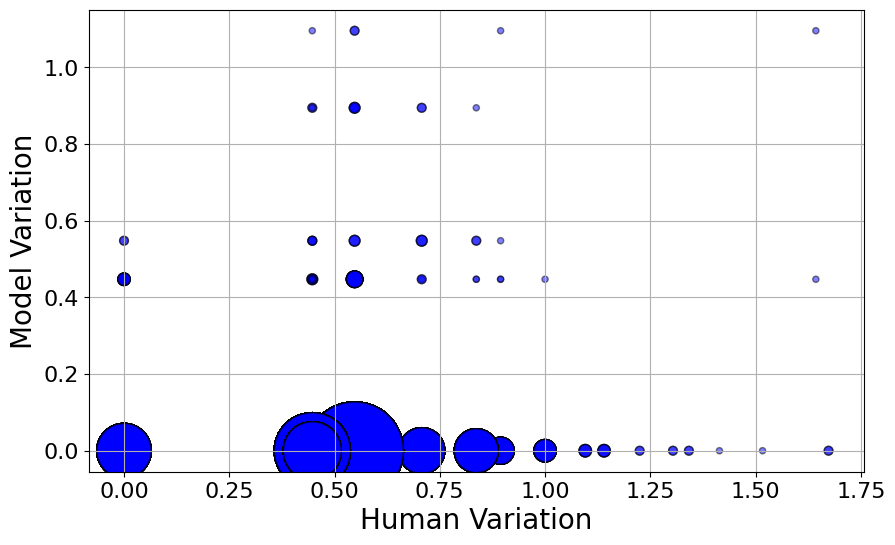

In [19]:
# Assuming filtered_sorted_df is your DataFrame with the necessary data
human_variation = filtered_sorted_df['human_variation']
model_variation = filtered_sorted_df['model_variation']

# Calculate overlaps
overlap_count = []
for i in range(len(filtered_sorted_df)):
    hv = human_variation.iloc[i]
    mv = model_variation.iloc[i]
    count = np.sum((human_variation == hv) & (model_variation == mv))
    overlap_count.append(count)

# Convert overlap_count to a suitable size for the plot
size = np.array(overlap_count) * 20  # Adjust the multiplier as needed

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(human_variation, model_variation, s=size, color='blue', edgecolors='black', alpha=0.5)  # Added size and alpha
plt.tick_params(axis='both', which='major', labelsize=16)
#plt.title('Human Variation vs Model Variation')
plt.xlabel('Human Variation', fontsize = 20)
plt.ylabel('Model Variation', fontsize = 20)
plt.grid(True)
plt.show()

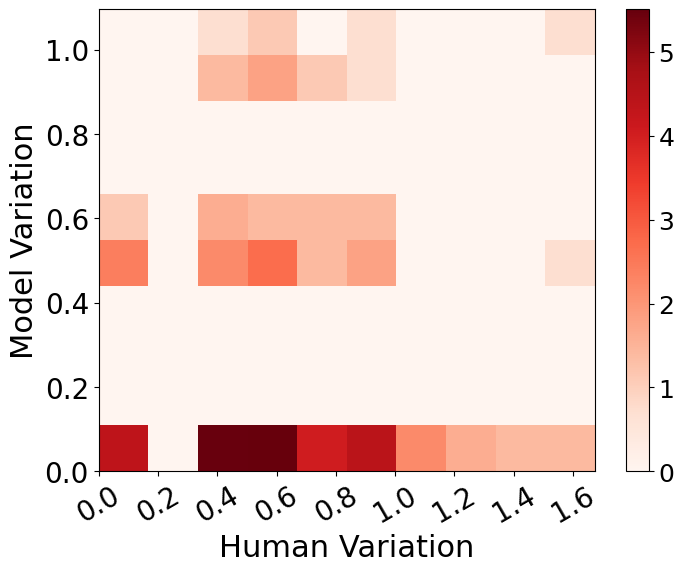

In [20]:
# The number of bins for the heatmap
bins = 10

# Creating a 2D histogram with the specified number of bins
heatmap, xedges, yedges = np.histogram2d(filtered_sorted_df['human_variation'], filtered_sorted_df['model_variation'], bins=bins)

# Instead of normalizing the heatmap, apply a logarithmic transformation to
# enhance the visibility of cells with lower counts.
# Add a small constant to avoid taking the log of zero.
log_heatmap = np.log(heatmap + 1)

# Plotting the heatmap
plt.figure(figsize=(8, 6))
im = plt.imshow(log_heatmap.T, origin='lower', cmap='Reds', interpolation='nearest', aspect='auto', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

# Adding a colorbar with increased font size
cbar = plt.colorbar(im)
cbar.ax.tick_params(labelsize=18)  # Increase font size for colorbar ticks

# Adding labels and title with increased font sizes
plt.xlabel('Human Variation', fontsize=22)
plt.ylabel('Model Variation', fontsize=22)

# Set x-ticks and y-ticks with rotation and increased font size
plt.xticks(rotation=30, fontsize=20)
plt.yticks(fontsize=20)

#plt.savefig("schem5_variation.pdf", format='pdf', bbox_inches='tight', dpi=300)
plt.show()

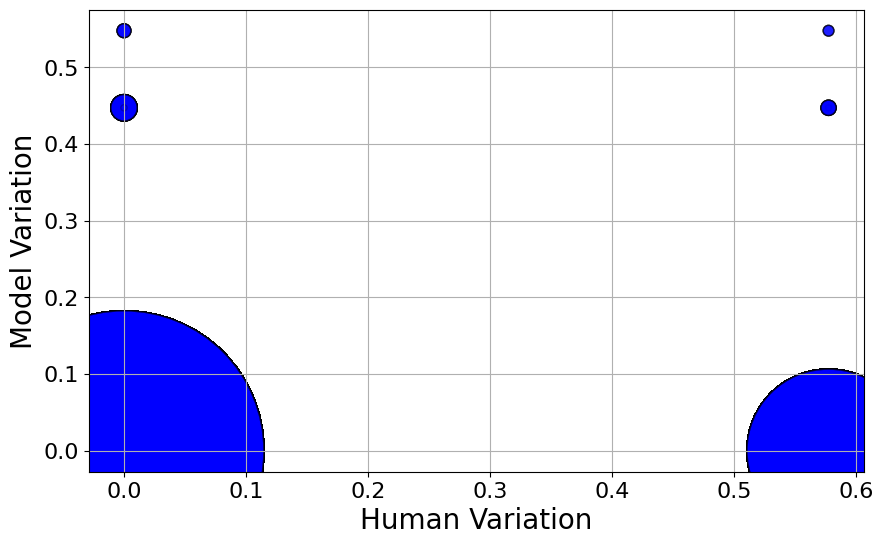

In [21]:
# Filter by dataset_name and sort by human_variation
filtered_sorted_df = df[(df['dataset_name'] == 'ghc') & (df['model_name'] == 'chatgpt') ].sort_values(by='human_variation', ascending=False)
# Plotting
# Assuming filtered_sorted_df is your DataFrame with the necessary data
human_variation = filtered_sorted_df['human_variation']
model_variation = filtered_sorted_df['model_variation']

# Calculate overlaps
overlap_count = []
for i in range(len(filtered_sorted_df)):
    hv = human_variation.iloc[i]
    mv = model_variation.iloc[i]
    count = np.sum((human_variation == hv) & (model_variation == mv))
    overlap_count.append(count)

# Convert overlap_count to a suitable size for the plot
size = np.array(overlap_count) * 20  # Adjust the multiplier as needed

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(human_variation, model_variation, s=size, color='blue', edgecolors='black', alpha=0.5)  # Added size and alpha
plt.tick_params(axis='both', which='major', labelsize=16)
#plt.title('Human Variation vs Model Variation')
plt.xlabel('Human Variation', fontsize = 20)
plt.ylabel('Model Variation', fontsize = 20)
plt.grid(True)
plt.show()

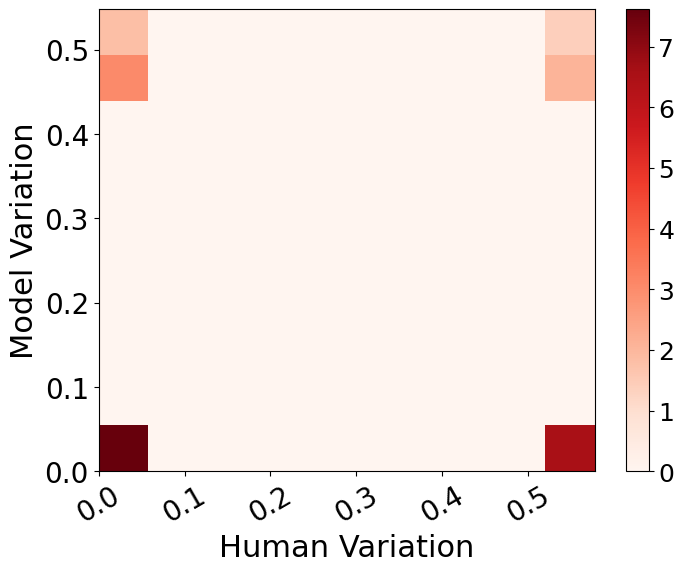

In [22]:
# The number of bins for the heatmap
bins = 10

# Creating a 2D histogram with the specified number of bins
heatmap, xedges, yedges = np.histogram2d(filtered_sorted_df['human_variation'], filtered_sorted_df['model_variation'], bins=bins)

# Instead of normalizing the heatmap, apply a logarithmic transformation to
# enhance the visibility of cells with lower counts.
# Add a small constant to avoid taking the log of zero.
log_heatmap = np.log(heatmap + 1)

# Plotting the heatmap
plt.figure(figsize=(8, 6))
im = plt.imshow(log_heatmap.T, origin='lower', cmap='Reds', interpolation='nearest', aspect='auto', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

# Adding a colorbar with increased font size
cbar = plt.colorbar(im)
cbar.ax.tick_params(labelsize=18)  # Increase font size for colorbar ticks

# Adding labels and title with increased font sizes
plt.xlabel('Human Variation', fontsize=22)
plt.ylabel('Model Variation', fontsize=22)

# Set x-ticks and y-ticks with rotation and increased font size
plt.xticks(rotation=30, fontsize=20)
plt.yticks(fontsize=20)

#plt.savefig("ghc_variation.pdf", format='pdf', bbox_inches='tight', dpi=300)
plt.show()

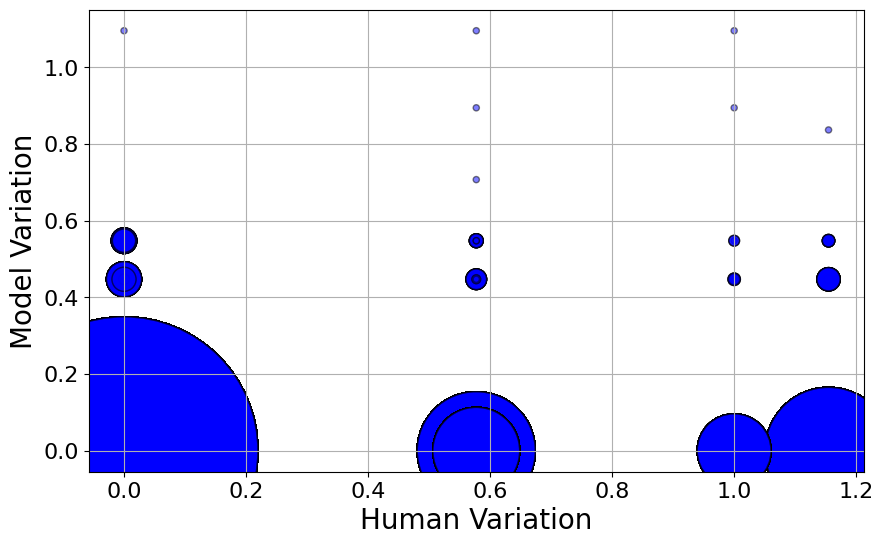

In [23]:
# Filter by dataset_name and sort by human_variation
filtered_sorted_df = df[(df['dataset_name'] == 'SBIC') & (df['model_name'] == 'chatgpt') ].sort_values(by='human_variation', ascending=False)
# Plotting
# Assuming filtered_sorted_df is your DataFrame with the necessary data
human_variation = filtered_sorted_df['human_variation']
model_variation = filtered_sorted_df['model_variation']

# Calculate overlaps
overlap_count = []
for i in range(len(filtered_sorted_df)):
    hv = human_variation.iloc[i]
    mv = model_variation.iloc[i]
    count = np.sum((human_variation == hv) & (model_variation == mv))
    overlap_count.append(count)

# Convert overlap_count to a suitable size for the plot
size = np.array(overlap_count) * 20  # Adjust the multiplier as needed

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(human_variation, model_variation, s=size, color='blue', edgecolors='black', alpha=0.5)  # Added size and alpha
plt.tick_params(axis='both', which='major', labelsize=16)
#plt.title('Human Variation vs Model Variation')
plt.xlabel('Human Variation', fontsize = 20)
plt.ylabel('Model Variation', fontsize = 20)
plt.grid(True)
plt.show()

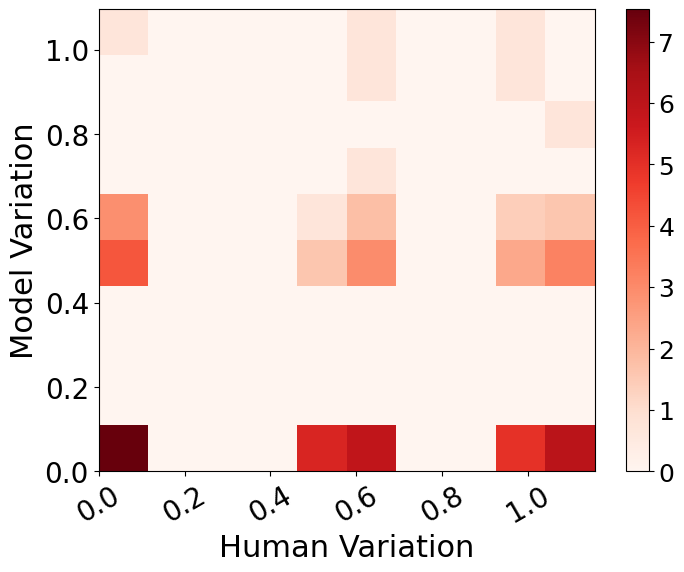

In [24]:
# The number of bins for the heatmap
bins = 10

# Creating a 2D histogram with the specified number of bins
heatmap, xedges, yedges = np.histogram2d(filtered_sorted_df['human_variation'], filtered_sorted_df['model_variation'], bins=bins)

# Instead of normalizing the heatmap, apply a logarithmic transformation to
# enhance the visibility of cells with lower counts.
# Add a small constant to avoid taking the log of zero.
log_heatmap = np.log(heatmap + 1)

# Plotting the heatmap
plt.figure(figsize=(8, 6))
im = plt.imshow(log_heatmap.T, origin='lower', cmap='Reds', interpolation='nearest', aspect='auto', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

# Adding a colorbar with increased font size
cbar = plt.colorbar(im)
cbar.ax.tick_params(labelsize=18)  # Increase font size for colorbar ticks

# Adding labels and title with increased font sizes
plt.xlabel('Human Variation', fontsize=22)
plt.ylabel('Model Variation', fontsize=22)

# Set x-ticks and y-ticks with rotation and increased font size
plt.xticks(rotation=30, fontsize=20)
plt.yticks(fontsize=20)

#plt.savefig("sbic_variation.pdf", format='pdf', bbox_inches='tight', dpi=300)
plt.show()

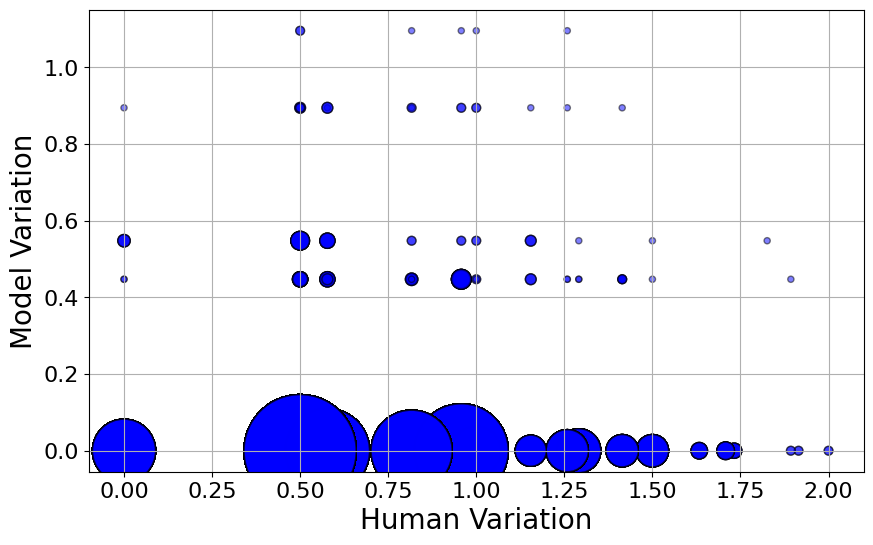

In [25]:
# Filter by dataset_name and sort by human_variation
filtered_sorted_df = df[(df['dataset_name'] == 'Sentiment') & (df['model_name'] == 'chatgpt') ].sort_values(by='human_variation', ascending=False)
# Plotting
# Assuming filtered_sorted_df is your DataFrame with the necessary data
human_variation = filtered_sorted_df['human_variation']
model_variation = filtered_sorted_df['model_variation']

# Calculate overlaps
overlap_count = []
for i in range(len(filtered_sorted_df)):
    hv = human_variation.iloc[i]
    mv = model_variation.iloc[i]
    count = np.sum((human_variation == hv) & (model_variation == mv))
    overlap_count.append(count)

# Convert overlap_count to a suitable size for the plot
size = np.array(overlap_count) * 20  # Adjust the multiplier as needed

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(human_variation, model_variation, s=size, color='blue', edgecolors='black', alpha=0.5)  # Added size and alpha
plt.tick_params(axis='both', which='major', labelsize=16)
#plt.title('Human Variation vs Model Variation')
plt.xlabel('Human Variation', fontsize = 20)
plt.ylabel('Model Variation', fontsize = 20)
plt.grid(True)
plt.show()

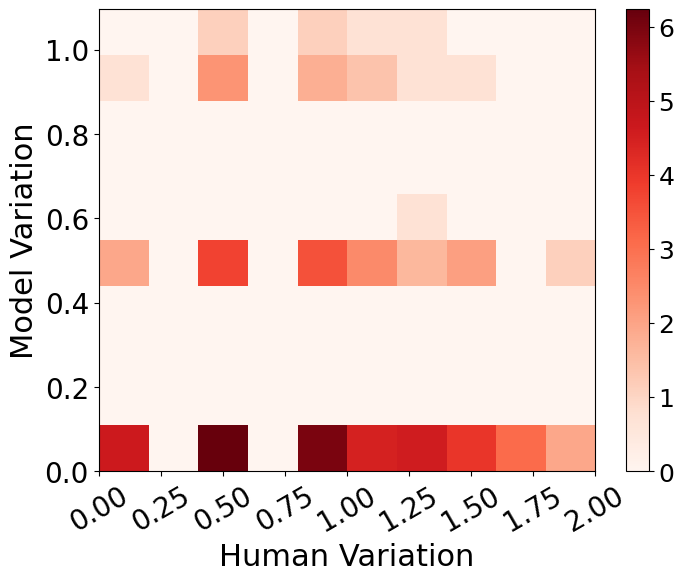

In [26]:
# The number of bins for the heatmap
bins = 10

# Creating a 2D histogram with the specified number of bins
heatmap, xedges, yedges = np.histogram2d(filtered_sorted_df['human_variation'], filtered_sorted_df['model_variation'], bins=bins)

# Instead of normalizing the heatmap, apply a logarithmic transformation to
# enhance the visibility of cells with lower counts.
# Add a small constant to avoid taking the log of zero.
log_heatmap = np.log(heatmap + 1)

# Plotting the heatmap
plt.figure(figsize=(8, 6))
im = plt.imshow(log_heatmap.T, origin='lower', cmap='Reds', interpolation='nearest', aspect='auto', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

# Adding a colorbar with increased font size
cbar = plt.colorbar(im)
cbar.ax.tick_params(labelsize=18)  # Increase font size for colorbar ticks

# Adding labels and title with increased font sizes
plt.xlabel('Human Variation', fontsize=22)
plt.ylabel('Model Variation', fontsize=22)

# Set x-ticks and y-ticks with rotation and increased font size
plt.xticks(rotation=30, fontsize=20)
plt.yticks(fontsize=20)

#plt.savefig("sent_variation.pdf", format='pdf', bbox_inches='tight', dpi=300)
plt.show()

### Qualitative Analysis ###

In [27]:
df.head()
df_og = df

In [28]:
df = df_og

In [29]:
df_mismatch = df[df['model_name'] == 'chatgpt']
df_mismatch = df_mismatch[(df_mismatch['human_minority']!=df_mismatch['machine_minority'])]

In [30]:
df_mismatch = df_mismatch[['text', 'human_annots', 'model_annots', 'human_variation', 'model_variation']]

In [31]:
df_mismatch.head()

,text,human_annots,model_annots,human_variation,model_variation
3160,You should support your partner.,"[3.0, 4.0, 3.0, 4.0, 3.0]","[3.0, 3.0, 3.0, 3.0, 3.0]",0.547723,0.0
3161,It's good to be want to know things that could...,"[3.0, 3.0, 3.0, 4.0, 4.0]","[3.0, 3.0, 3.0, 3.0, 3.0]",0.547723,0.0
3162,It is good to have moderation in all activities.,"[2.0, 3.0, 2.0, 3.0, 4.0]","[3.0, 3.0, 3.0, 3.0, 3.0]",0.836660,0.0
3163,It is wrong to be racist to other people.,"[3.0, 4.0, 3.0, 3.0, 3.0]","[4.0, 4.0, 4.0, 4.0, 4.0]",0.447214,0.0
3164,It's normal to be clean-shaven for special occ...,"[2.0, 3.0, 2.0, 3.0, 2.0]","[3.0, 3.0, 3.0, 3.0, 3.0]",0.547723,0.0


In [32]:
df_mismatch.shape

(8032, 5)

In [33]:
df_mismatch_sorted = df_mismatch.sort_values(by='model_variation', ascending=True)
df_mismatch_sorted.reset_index(drop=True, inplace=True)


In [34]:
pd.set_option('display.max_colwidth', None)
df_mismatch_sorted.head(20)

,text,human_annots,model_annots,human_variation,model_variation
0,You should support your partner.,"[3.0, 4.0, 3.0, 4.0, 3.0]","[3.0, 3.0, 3.0, 3.0, 3.0]",0.547723,0.0
1,Did you miss our new Mondrian - Plastic Reality Gameplay Trailer this week? You did?? You poor soul. Check it out right here & grab the game in Early Access on itch.io or GameJolt! http://bit.ly/mondrianEX4Trailer #indiegames #gamedev #gabgaming #edtech #gaming #makeamondrian #kidsgames #arthistory #art,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,0.0
2,Cool. I'll check it out. #music #StevePerryhttp://www.blabbermouth.net/news/former-journey-si...,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,0.0
3,Yup.,"[1.0, 1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0]",0.577350,0.0
4,"3000 years ago, would have been around 900 CE, Jeroboam 1 and Jehoahaz were the kings of Judea and Israel and neither of them were called Messiah. They were called kings:","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,0.0
5,"This country was founded by white colonists, who built this land out of nothingness, who tamed the land and tilled the soil, creating a new civilization on this continent. There is no melting pot if you are of the same race.","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,0.0
6,"The frenetic, varied, and vivacious ""Dance of the Zaporozhye Cossacks"".","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,0.0
7,Corruption is cancer and the doctor needs to share the report to (his/her) patient. This info is not confidential....#ReleaseTheMemo #WeThePeople deserve to know the health report of our nation!,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,0.0
8,If #Hitler were alive today I'm damn sure he'd have gold teeth.. I wish I could afford some,"[0.0, 0.0, 0.0]","[1.0, 1.0, 1.0, 1.0, 1.0]",0.000000,0.0
9,10] A) BIBLE STUDY of ENOCH & the ANGELS 10 HANOCH - ENOCH 10,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,0.0


In [35]:
#df_mismatch_sorted.to_csv("mismatch.csv", index = False, header = True)

### Label Flipping Analysis ###

In [36]:
df.head()

,model_name,dataset_name,text_ind,text,prompt,human_annots,model_annots,human_majority,machine_majority,human_minority,machine_minority,majority_match,minority_match,human_variation,model_variation
0,vicuna,SChem5Labels,0,You should support your partner.,"For this task, we want to study people's everyday social norms and moral judgments over a rich spectrum of real life situations.\nAs a responsible Mechanical Turk worker, your task is to respond to the given problem in a concise manner as specified. Your opinion should match that of a randomly chosen individual from a diverse group of people representing all kinds of backgrounds, political opinions, socioeconomic statuses, and so on. You may respond using your persona’s personal biases and opinions. Please carefully follow the instructions below and label the given sentence using the provided options.\nSentence: You should support your partner.\nLabel options: (0) Almost no one believes this, (1) People occasionally think this, (2) Controversial, (3) Common belief, (4) Universally true\nAmong the given options, I think the most appropriate option is (","[3.0, 4.0, 3.0, 4.0, 3.0]","[4.0, 3.0, 3.0, 4.0, 3.0]",[3.0],[3.0],[4.0],[4.0],True,True,0.547723,0.547723
1,vicuna,SChem5Labels,1,It's good to be want to know things that could be important.,"For this task, we want to study people's everyday social norms and moral judgments over a rich spectrum of real life situations.\nAs a responsible Mechanical Turk worker, your task is to respond to the given problem in a concise manner as specified. Your opinion should match that of a randomly chosen individual from a diverse group of people representing all kinds of backgrounds, political opinions, socioeconomic statuses, and so on. You may respond using your persona’s personal biases and opinions. Please carefully follow the instructions below and label the given sentence using the provided options.\nSentence: It's good to be want to know things that could be important.\nLabel options: (0) Almost no one believes this, (1) People occasionally think this, (2) Controversial, (3) Common belief, (4) Universally true\nAmong the given options, I think the most appropriate option is (","[3.0, 3.0, 3.0, 4.0, 4.0]","[0.0, 3.0, 3.0, 4.0, 3.0]",[3.0],[3.0],[4.0],"[0.0, 4.0]",True,True,0.547723,1.516575
2,vicuna,SChem5Labels,2,It is good to have moderation in all activities.,"For this task, we want to study people's everyday social norms and moral judgments over a rich spectrum of real life situations.\nAs a responsible Mechanical Turk worker, your task is to respond to the given problem in a concise manner as specified. Your opinion should match that of a randomly chosen individual from a diverse group of people representing all kinds of backgrounds, political opinions, socioeconomic statuses, and so on. You may respond using your persona’s personal biases and opinions. Please carefully follow the instructions below and label the given sentence using the provided options.\nSentence: It is good to have moderation in all activities.\nLabel options: (0) Almost no one believes this, (1) People occasionally think this, (2) Controversial, (3) Common belief, (4) Universally true\nAmong the given options, I think the most appropriate option is (","[2.0, 3.0, 2.0, 3.0, 4.0]","[3.0, 3.0, 3.0, 4.0, 3.0]","[2.0, 3.0]",[3.0],[4.0],[4.0],True,True,0.836660,0.447214
3,vicuna,SChem5Labels,3,It is wrong to be racist to other people.,"For this task, we want to study people's everyday social norms and moral judgments over a rich spectrum of real life situations.\nAs a responsible Mechanical Turk worker, your task is to respond to the given problem in a concise manner as specified. Your opinion should match that of a randomly chosen individual from a diverse group of people representing all kinds of backgrounds, political opinions, socioeconomic statuses, and so on. You may respond using your persona’s personal biases and opinions. Please carefully follow the instruc

In [37]:
gpt_df = df[df['model_name'] == 'chatgpt'][['model_name', 'dataset_name', 'text', 'human_annots', 'model_annots', 'human_variation', 'model_variation']]
gpt_df.head()

,model_name,dataset_name,text,human_annots,model_annots,human_variation,model_variation
3160,chatgpt,SChem5Labels,You should support your partner.,"[3.0, 4.0, 3.0, 4.0, 3.0]","[3.0, 3.0, 3.0, 3.0, 3.0]",0.547723,0.0
3161,chatgpt,SChem5Labels,It's good to be want to know things that could be important.,"[3.0, 3.0, 3.0, 4.0, 4.0]","[3.0, 3.0, 3.0, 3.0, 3.0]",0.547723,0.0
3162,chatgpt,SChem5Labels,It is good to have moderation in all activities.,"[2.0, 3.0, 2.0, 3.0, 4.0]","[3.0, 3.0, 3.0, 3.0, 3.0]",0.836660,0.0
3163,chatgpt,SChem5Labels,It is wrong to be racist to other people.,"[3.0, 4.0, 3.0, 3.0, 3.0]","[4.0, 4.0, 4.0, 4.0, 4.0]",0.447214,0.0
3164,chatgpt,SChem5Labels,It's normal to be clean-shaven for special occasions.,"[2.0, 3.0, 2.0, 3.0, 2.0]","[3.0, 3.0, 3.0, 3.0, 3.0]",0.547723,0.0


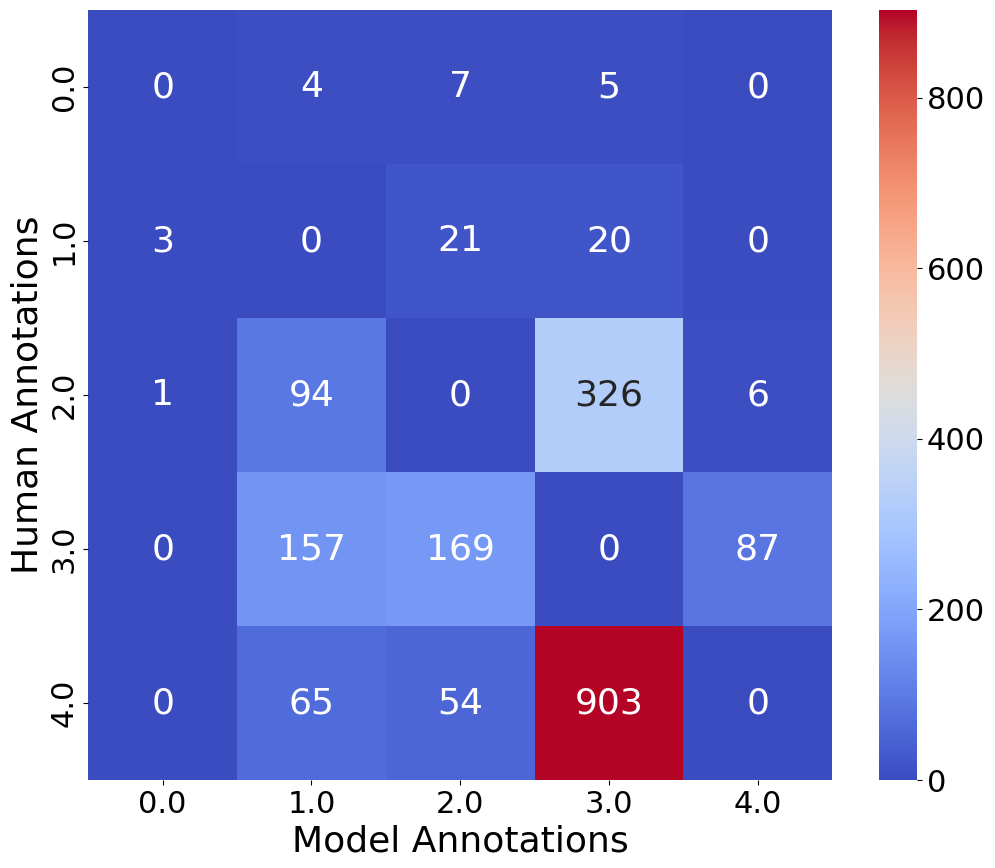

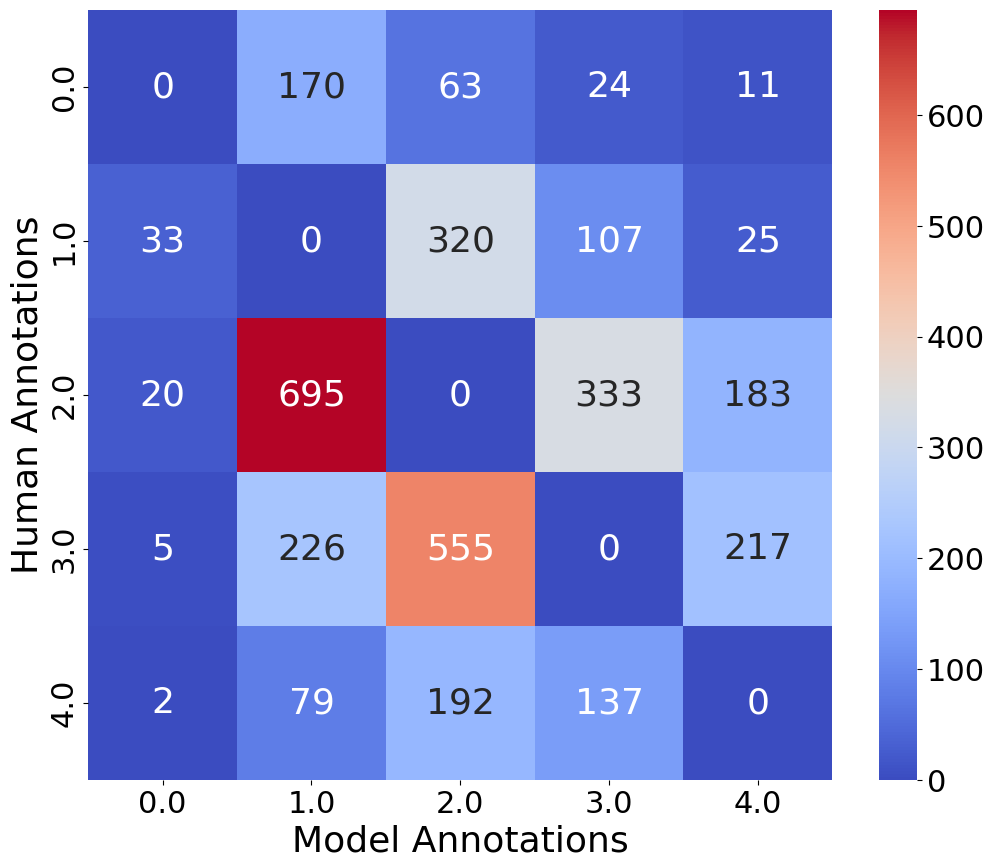

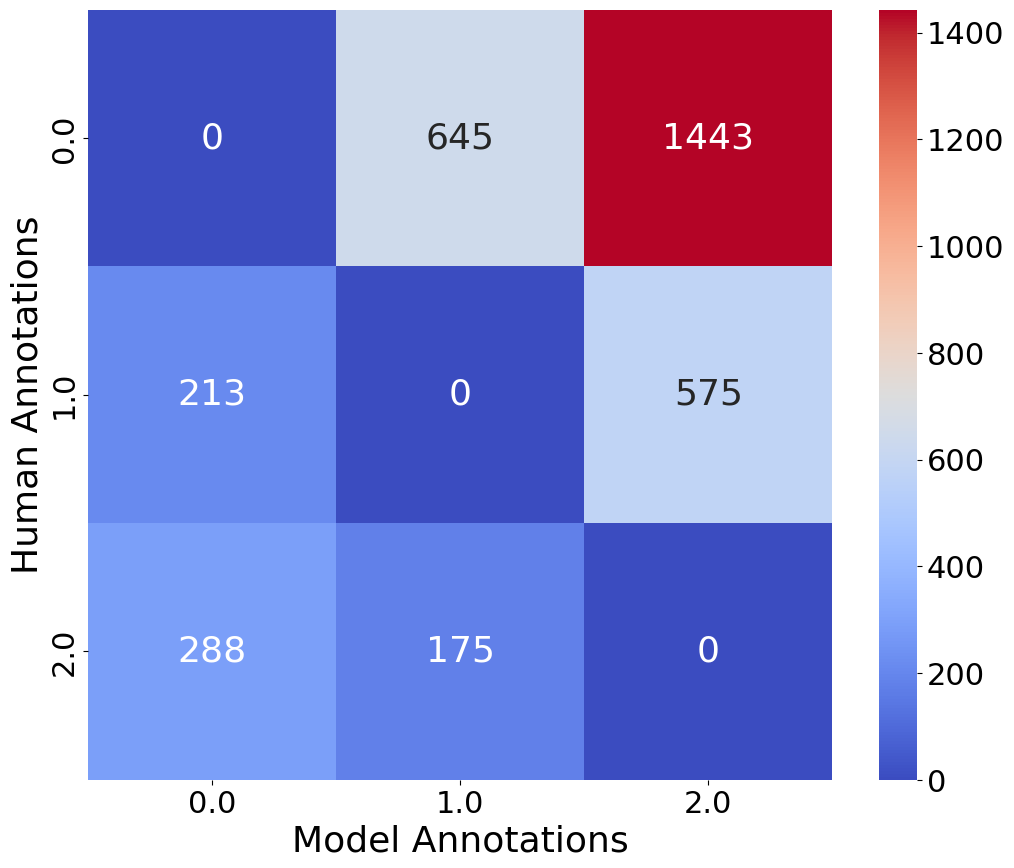

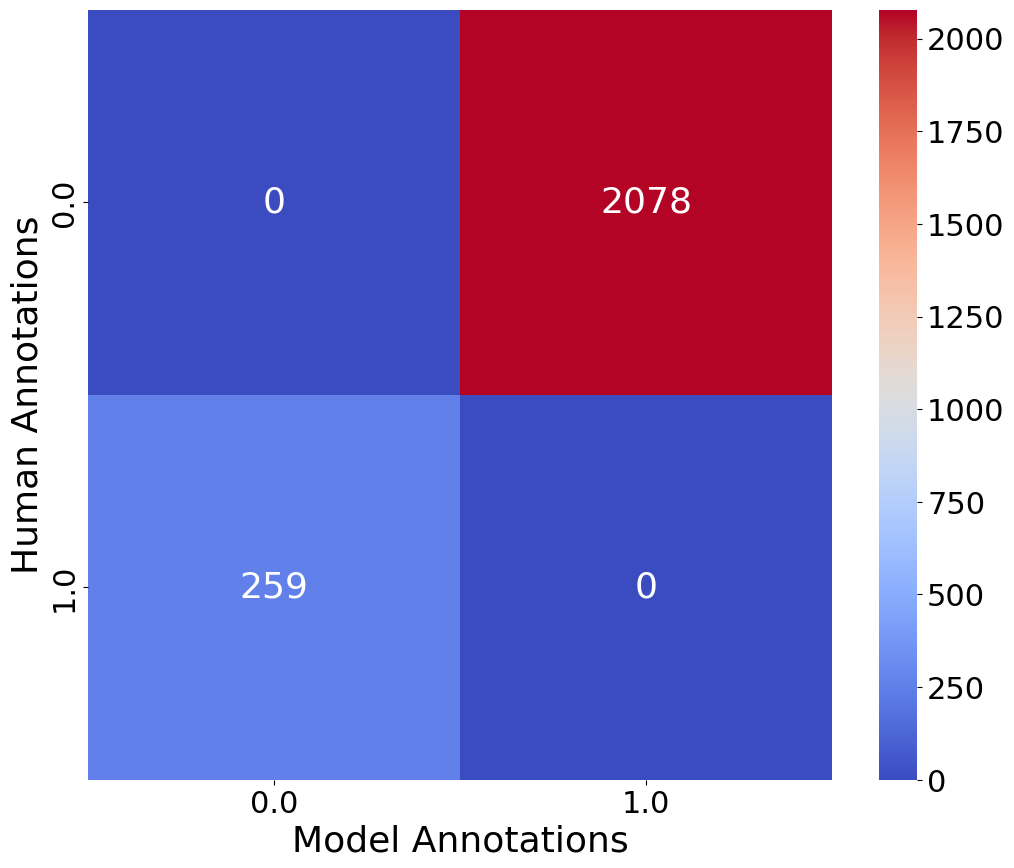

In [38]:
# Function to calculate label flipping frequencies for each dataset
def calculate_label_flipping(df):
    # Create a dictionary to hold the flip matrix for each dataset
    flip_matrices = {}

    # Get unique datasets
    datasets = df['dataset_name'].unique()

    # Iterate over each dataset
    for dataset in datasets:
        df_subset = df[df['dataset_name'] == dataset]

        # Find all unique labels across all annotations in this subset
        unique_labels = sorted(set(label for annot_list in df_subset['human_annots'] for label in annot_list))
        label_to_index = {label: idx for idx, label in enumerate(unique_labels)}

        # Create an empty matrix for label flipping counts
        flip_matrix = np.zeros((len(unique_labels), len(unique_labels)), dtype=int)

        # Iterate over the DataFrame rows
        for _, row in df_subset.iterrows():
            human_labels = row['human_annots']
            model_labels = row['model_annots']

            # Compare human and model annotations and count label flips
            for h_label, m_label in zip(human_labels, model_labels):
                if h_label != m_label:
                    flip_matrix[label_to_index[h_label], label_to_index[m_label]] += 1

        flip_matrices[dataset] = (flip_matrix, unique_labels)

    return flip_matrices

# Calculate the label flipping matrix for each dataset
flip_matrices = calculate_label_flipping(gpt_df)

# Now let's plot the heatmap for each dataset with increased font sizes
for dataset, (matrix, labels) in flip_matrices.items():
    plt.figure(figsize=(12, 10))  # Increase the figure size for better visibility
    ax = sns.heatmap(matrix, annot=True, cmap='coolwarm', fmt='d',
                     xticklabels=labels, yticklabels=labels)
    # Increase font sizes for the heatmap
    #ax.set_title(f'Heatmap of Label Flipping for {dataset}', fontsize=20)  # Increase title font size
    ax.set_xlabel('Model Annotations', fontsize=26)  # Increase X-axis label font size
    ax.set_ylabel('Human Annotations', fontsize=26)  # Increase Y-axis label font size
    ax.tick_params(axis='both', labelsize=22)  # Increase axis tick font size

    # Increase annotation font size within the heatmap cells
    for t in ax.texts:
        t.set_text(t.get_text())
        t.set_size(26)
     # Retrieve the colorbar, increase its label size, and re-draw the plot
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=22)

    #plt.savefig(f'{dataset}_label_flip.pdf', format='pdf', bbox_inches='tight', dpi=300)
    plt.show()